Forked from 2019 Stefan Jansen
https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/22_deep_reinforcement_learning/04_q_learning_for_trading.ipynb

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from datetime import datetime
from random import sample
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
tf.compat.v1.disable_eager_execution()

import gym
from gym.envs.registration import register

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


### Helper functions

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

In [6]:
trading_days = 252

In [7]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days,
    kwargs={'trading_days': 252,
            'trading_cost_bps': 1e-3,
            'time_cost_bps': 1e-4,
            'ticker': 'MSFT'}
)

### Initialize Trading Environment

In [8]:
trading_environment = gym.make('trading-v0')
trading_environment.seed(42)

2020-11-17 11:01:55,342 INFO     trading_env logger started
2020-11-17 11:01:55,344 INFO     loading data for MSFT...


data already saved C:\Users\Jameshuckle\Dropbox\My-Portfolio\DataScience/data/SP500_all_stock_data_2000-01-01-2020-11-1.csv
[*********************100%***********************]  1 of 1 completed

2020-11-17 11:01:55,810 INFO     got data for MSFT...
2020-11-17 11:01:55,833 INFO     None



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5209 entries, 2000-02-18 to 2020-10-30
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  5209 non-null   float64
 1   ret_2    5209 non-null   float64
 2   ret_5    5209 non-null   float64
 3   ret_10   5209 non-null   float64
 4   ret_21   5209 non-null   float64
 5   rsi      5209 non-null   float64
 6   macd     5209 non-null   float64
 7   atr      5209 non-null   float64
 8   stoch    5209 non-null   float64
 9   ultosc   5209 non-null   float64
dtypes: float64(10)
memory usage: 447.6 KB


[42]

In [9]:
#trading_environment.env.data_source.load_data()[['high','low','close']].plot()

### Get Environment params

In [10]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Define Trading Agent

In [11]:
class DDQNAgent:
    def __init__(self, state_dim, num_actions, learning_rate, gamma, epsilon_start,
                 epsilon_end, epsilon_decay_steps, epsilon_exponential_decay, replay_capacity,
                 architecture, l2_reg, tau, batch_size, train):
        
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg
        
        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()
        
        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []
        
        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []
        
        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = train
        
    
    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        #minibatch = (np.array(i) for i in sample(self.experience, self.batch_size))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        # best_actions = tf.argmax(next_q_values, axis=1) # original slow eager exc
        best_actions = np.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        #  target_q_values = tf.gather_nd(
        #            next_q_values_target,
        #            tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1)) # original slow eacher exc
        target_q_values = next_q_values_target[range(len(next_q_values_target)), best_actions]

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        #q_values[tuple([self.idx, actions])] = targets # original slow eager exc
        q_values[tuple([range(self.batch_size), actions])] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [12]:
gamma = .99 # discount factor
tau = 100 # target network update frequency

### NN Architecture
architecture = (256, 256) # units per layer
learning_rate = 1e-4 
l2_reg = 1e-6

### Experience Replay
replay_capacity = int(1e6)
batch_size = 4096

### e-greedy Policy
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

## Create DDQN Agent (TF)

In [13]:
tf.keras.backend.clear_session()

train = False #set to False to test ddqn
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 train=train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-11-17 11:01:55,989 WARNING  From C:\Users\Jameshuckle\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
load_weights = True

if ddqn.train == False or load_weights:
    print('>>> loading weights')
    ddqn.online_network.load_weights(
        f'./results/trading_bot_2020-11-16_17-37/model_weights/model_weights')
    ddqn.update_target()
    if ddqn.train == False:
        ddqn.epsilon = 0

>>> loading weights


In [15]:
#ddqn.online_network.summary()

## Run Experiment

### Set parameters

In [16]:
total_steps = 0
max_episodes = 1000

### Initialize variables
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

## Visualization

In [17]:
def track_results(episode, nav_ma_100, nav_ma_10, market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = (f'{episode:>4d} | {format_time(total)} | '
                f'Agent: {nav_ma_100-1:>6.1%} ({nav_ma_10-1:>6.1%}) | '
                f'Market: {market_nav_100-1:>6.1%} ({market_nav_10-1:>6.1%}) | '
                f'Wins: {win_ratio:>5.1%} | eps: {epsilon:>6.3f}')
    print(template)

### Train Agent

In [18]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    result = trading_environment.env.simulator.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 10 == 0:
        track_results(episode, np.mean(navs[-100:]), np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), np.mean(market_navs[-10:]), 
                      np.sum([s > 0 for s in diffs[-100:]]) / min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

------
start_position 0.0
start_nav 1.0
start_market_nav 1.0
action 0
end_position -1
n_trades -1.0
------
start_position -1.0
start_nav 1.0
start_market_nav 1.0
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9932880321137318
start_market_nav 1.0066119678862682
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9945386159705556
start_market_nav 1.0052439475384332
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9966948287841088
start_market_nav 1.0029640005997755
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9950091549551129
start_market_nav 1.0045599808517158
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.999652159730229
start_market_nav 0.9997719531214937
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9988682228169375
start_market_nav 1.0004560067826116
action 0
end_position -1
n_trades 0.0
------
start_position

n_trades 1.0
------
start_position 0.0
start_nav 0.9375700875191172
start_market_nav 1.0066119678862668
action 0
end_position -1
n_trades -1.0
------
start_position -1.0
start_nav 0.936632517431598
start_market_nav 1.0134518956766405
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9375924179700432
start_market_nav 1.0123119222073116
action 1
end_position 0
n_trades 1.0
------
start_position 0.0
start_nav 0.9368660401189853
start_market_nav 1.0120838753288055
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.9359291740788663
start_market_nav 1.0100318882942534
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9345680085558494
start_market_nav 1.008663954920819
action 0
end_position -1
n_trades -2.0
------
start_position -1.0
start_nav 0.9386138339229485
start_market_nav 1.0150478759285808
action 0
end_position -1
n_trades 0.0
------
start_position -1.0
start_nav 0.9366225020228092
start_market_nav 1.017099862

------
start_position 0.0
start_nav 0.7676210779029651
start_market_nav 1.0170998629631338
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.7668534568250621
start_market_nav 1.0389876666820896
action 0
end_position -1
n_trades -2.0
------
start_position -1.0
start_nav 0.7831574879581791
start_market_nav 1.0631555043141039
action 1
end_position 0
n_trades 1.0
------
start_position 0.0
start_nav 0.7803589313730761
start_market_nav 1.0658914580353733
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7802808954799388
start_market_nav 1.0670314315047023
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7802028673903909
start_market_nav 1.0818513475291789
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7801248471036519
start_market_nav 1.074099406173582
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7800468346189415
start_market_nav 1.071591412356418
action 1
end

------
start_position 0.0
start_nav 0.7903671126759093
start_market_nav 1.2323301068150005
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7902880759646417
start_market_nav 1.1894664259679117
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.7894977878886771
start_market_nav 1.193114480228805
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7889661918121532
start_market_nav 1.1924304265676873
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7961282782987885
start_market_nav 1.203374328427165
action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 0.7781365120452481
start_market_nav 1.177382550639105
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.7780586983940436
start_market_nav 1.2108983098786565
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.7772806396956495
start_market_nav 1.162562721589029
action 2
end_pos

action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 0.994582988062359
start_market_nav 0.9080730638538069
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.9935884050742967
start_market_nav 0.8412885869067995
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.0519489887585052
start_market_nav 0.8907876372037817
action 0
end_position -1
n_trades -2.0
------
start_position -1.0
start_nav 1.117114192769763
start_market_nav 0.947750935859661
action 1
end_position 0
n_trades 1.0
------
start_position 0.0
start_nav 1.1194700077686295
start_market_nav 0.9448045299211716
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.1193580607678526
start_market_nav 0.9424474501285095
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.1192461249617758
start_market_nav 0.8986446697529428
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.1191342003492797
start_marke

------
start_position 1.0
start_nav 1.1958931274222258
start_market_nav 1.0895698563535323
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.153948487887668
start_market_nav 1.051463345899381
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.1641804638324802
start_market_nav 1.060891740000245
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.1780747679006323
start_market_nav 1.073659399160078
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.1673960636942016
start_market_nav 1.0640345380338665
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 1.1312898584296827
start_market_nav 1.0312315882410823
action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 1.172824347653679
start_market_nav 1.0701237420059773
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 1.1716515233060254
start_market_nav 1.067766662213315
action 2
end_posit

action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 0.7553959891247948
start_market_nav 1.0111962226779154
action 0
end_position -1
n_trades -1.0
------
start_position -1.0
start_nav 0.75464059313567
start_market_nav 1.0135533024705774
action 1
end_position 0
n_trades 1.0
------
start_position 0.0
start_nav 0.7606133554924085
start_market_nav 1.004517767490193
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.7598527421369161
start_market_nav 1.010410504436956
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7710032289206699
start_market_nav 1.0253388512943191
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7638364505990104
start_market_nav 1.0159104571934552
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7788241332895812
start_market_nav 1.035945822756622
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.7675231187903541
start_market_

action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 1.0005719327286775
start_market_nav 1.1721542564002458
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0004718755354047
start_market_nav 1.171299122179211
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.000371828347851
start_market_nav 1.1670230595888147
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0002717911650163
start_market_nav 1.1789105083703137
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0001717639858998
start_market_nav 1.1836140728236906
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0000717468095013
start_market_nav 1.187890135414087
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.9999717396348203
start_market_nav 1.187890135414087
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.9998717424608569
start_market_na

------
start_position 0.0
start_nav 1.0168502427080028
start_market_nav 1.1602668076187463
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.016748557683732
start_market_nav 1.1822458319710194
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0166468828279638
start_market_nav 1.1896006648463042
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.016545218139681
start_market_nav 1.1945607826154987
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.016443563617867
start_market_nav 1.193449095078646
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.0163419192615053
start_market_nav 1.2107244244824682
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.016240285069579
start_market_nav 1.2008039279539306
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 1.016138661041072
start_market_nav 1.194646387384154
action 1
end_positio

start_market_nav 1.3963909890802377
action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 0.9914759061454643
start_market_nav 1.3865560973203557
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.9913767585548497
start_market_nav 1.3955357243641286
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.9912776208789943
start_market_nav 1.4211066256329257
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start_nav 0.9911784931169064
start_market_nav 1.4290601699085015
action 2
end_position 1
n_trades 1.0
------
start_position 1.0
start_nav 0.9901873146237895
start_market_nav 1.423928842601996
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9853306209763457
start_market_nav 1.417087116358347
action 1
end_position 0
n_trades -1.0
------
start_position 0.0
start_nav 0.9904107186093989
start_market_nav 1.4258103205813764
action 1
end_position 0
n_trades 0.0
------
start_position 0.0
start

start_nav 0.9497797308305604
start_market_nav 1.0588235381532507
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9486364068763526
start_market_nav 1.057654832015489
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9446981260775101
start_market_nav 1.0533697247822984
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9505428924410013
start_market_nav 1.0599921699883779
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9591812351053005
start_market_nav 1.069731164895155
action 2
end_position 1
n_trades 0.0
------
start_position 1.0
start_nav 0.9611811725265863
start_market_nav 1.0720685771706786


KeyboardInterrupt: 

### Store Results

In [68]:
save = False
if save:
    date_now = datetime.now().strftime('%Y-%m-%d_%H-%M')
    results_path = Path('results', f'trading_bot_{date_now}')
    if not results_path.exists():
        results_path.mkdir(parents=True)
        
    ddqn.online_network.save_weights(f'{results_path}/model_weights/model_weights')

In [69]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


In [70]:
if save:
    results.to_csv(results_path / f'results.csv', index=False)

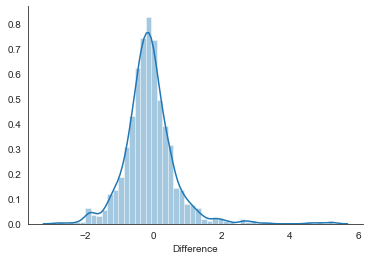

In [71]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

### Evaluate results

In [72]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data for which there are some 9,000 daily price and volume observations. Training stopped after 14,000 trading periods when the agent beat the market 10 consecutive times.

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~3,000 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In a few instances, it beats the market about half the time out of 100 periods:

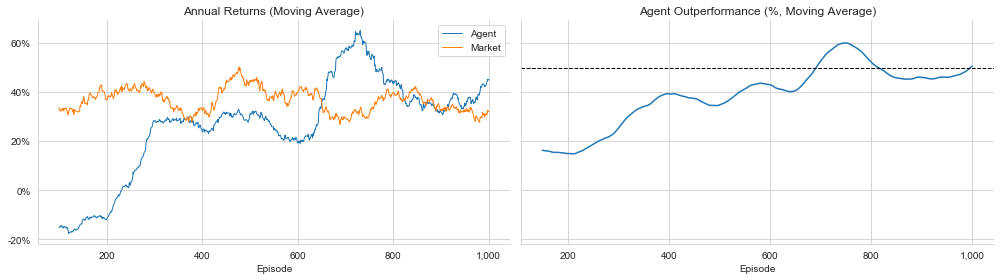

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
if save:
    fig.savefig(results_path / 'performance', dpi=300)

## Things to do
- Format input data to sliding window to incorporate more data / features
- Use an LSTM rather an DNN